In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motrak')
out_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
timing = pd.read_csv(os.path.join(study_dir, 'measures','clips','ClipsTimingForAnalysis.csv'), index_col=0)
subinfo = pd.read_csv(os.path.join(study_dir,'DATA','redcap_exports','ChildMovieStudy-Basics_DATA_2025-07-15_1335.csv'),index_col=0)
subinfo.index = subinfo.index.astype(str)

#subIDs = ['2024','2025','2026']
subIDs = sorted(os.listdir(data_dir))[1:]

2002
2003
2004
2005
2006
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2042
2043
2044
2045
2046
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2062
2063


/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motion.loc[:,'movie_d'] = pd.to_datetime(motion.loc[:,'Movie Time'])
/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True  True  True]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  motion.loc[:,'movie_d'] = motion['Movie Time'].eq(motion['Movie Time'].shift())
/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected

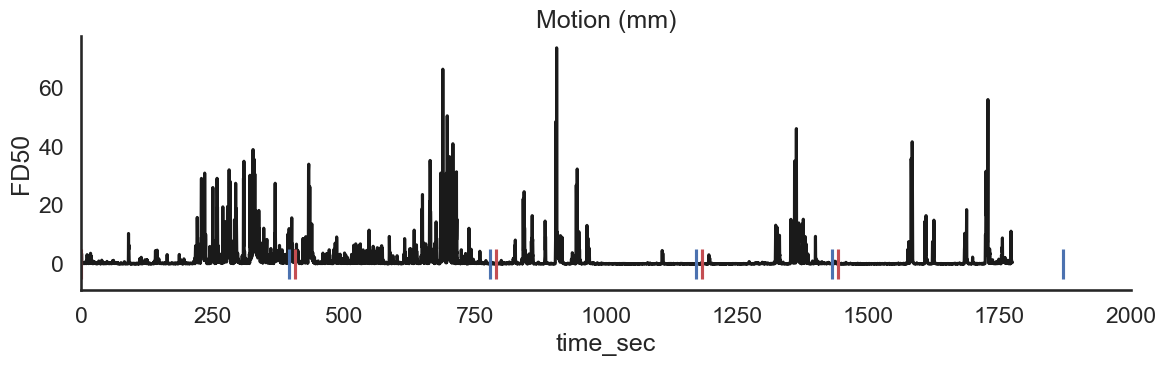

2065


/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motion.loc[:,'movie_d'] = pd.to_datetime(motion.loc[:,'Movie Time'])
/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True ...  True  True  True]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  motion.loc[:,'movie_d'] = motion['Movie Time'].eq(motion['Movie Time'].shift())
/var/folders/nz/4sv1wxqx0k794wx0y3j__0vm0000gp/T/ipykernel_60054/3216770691.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected

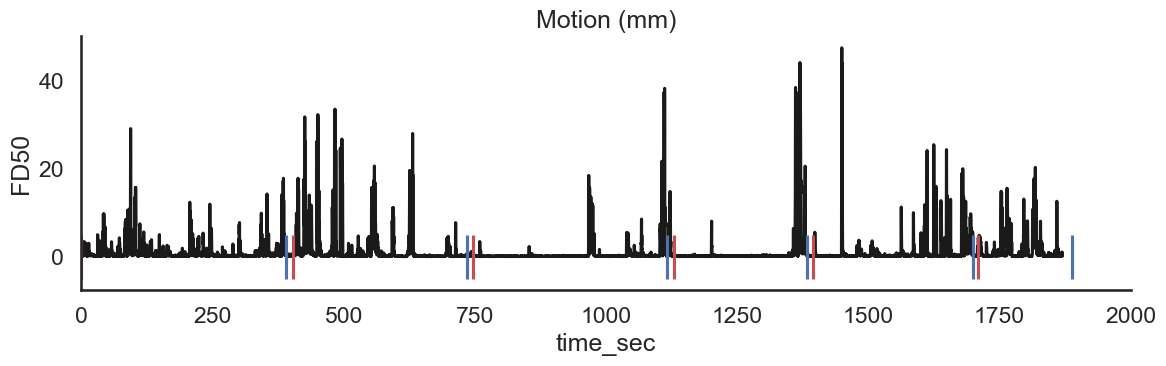

In [4]:
for sub in subIDs:
    print(sub)
    if not os.path.isdir(os.path.join(out_dir,sub)):
        os.makedirs(os.path.join(out_dir,sub),exist_ok=True)
        file = glob(os.path.join(data_dir, sub, '*.txt'))[0]
        motion = pd.read_csv(file, index_col=0, delimiter='\t')

        listnum = int(os.path.basename(file).split('_')[1][-1])
        versnum = int(os.path.basename(file).split('_')[2][-1])
        oldnew = os.path.basename(file).split('_')[3][:-4]
        subtime = timing.loc[(timing['set']==listnum) & (timing['version']==versnum) & (timing['clips_version']==oldnew),:]

        # identify frames where movie is not playing
        motion.loc[:,'movie_d'] = pd.to_datetime(motion.loc[:,'Movie Time'])
        motion.loc[:,'movie_d'] = motion['Movie Time'].eq(motion['Movie Time'].shift())
        motion.to_csv(os.path.join(out_dir,sub,'{0}_motion_data_temp.csv'.format(sub)))

        # convert index to datetime then seconds
        origind = motion.index
        motion.index = pd.to_datetime(origind)
        zeroed_times = motion.loc[motion['Events']=='Zeroed',:].index.to_numpy()
        motion = motion.drop(['Position circle','Angle circle','Events', 'Movie Time'], axis=1).copy()
        motion = motion.resample('200ms').mean()
        time = np.arange(0,len(motion)/5,0.2)
        motion.index = time
        motion.index.name = 'time_sec'

        # compute 1st derive of motion
        for a in motion.columns:
            motion.loc[:, '{0}1'.format(a)] = np.gradient(motion.loc[:,a])

        # compute FD (adult head size)
        ang = np.absolute(motion.loc[:,['Pitch1','Yaw1','Roll1']])
        ang = ang.loc[:,['Pitch1','Yaw1','Roll1']].sum(min_count=1,axis=1)
        transl = np.absolute(motion.loc[:,['X1','Y1','Z1']])
        transl = transl.loc[:,['X1','Y1','Z1']].sum(min_count=1,axis=1)
        motion.loc[:, 'FD50'] = transl + 50*(np.pi/180)*ang

        # drop frames where movie is not playing
        motion = motion.iloc[1:,:]
        motion = motion.loc[motion['movie_d']==False,:].copy()
        motion.index = np.arange(0,len(motion)/5,0.2)
        motion.index.name = 'time_sec'

        # summarize motion for each clip separately
        motion_summary = pd.DataFrame()
        for i, v in enumerate(subtime.index):
            motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],'title'] = v
            tempmotion = motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],:]
            motion_summary.loc[v, 'meanFD'] = tempmotion['FD50'].mean(axis=0)
            motion_summary.loc[v, 'minFD'] = tempmotion['FD50'].min(axis=0)
            motion_summary.loc[v, 'maxFD'] = tempmotion['FD50'].max(axis=0)
            motion_summary.loc[v, 'sdFD'] = tempmotion['FD50'].std(axis=0)
            motion_summary.loc[v, 'pcent_volscens_0.9'] = np.nanmean(tempmotion['FD50']>0.9)
            motion_summary.loc[v, 'pcent_volscens_0.2'] = np.nanmean(tempmotion['FD50']>0.2)
            # pull ratings
            if '2051' not in sub: 
                if (np.isfinite(subinfo.loc[sub,'interest{0}_v2'.format(i+1)])):
                    motion_summary.loc[v, 'interest'] = subinfo.loc[sub,'interest{0}_v2'.format(i+1)]
                    motion_summary.loc[v, 'pos_aff'] = subinfo.loc[sub,'p_affect{0}_v2'.format(i+1)]
                    motion_summary.loc[v, 'neg_aff'] = subinfo.loc[sub,'n_affect{0}_v2'.format(i+1)]
                    motion_summary.loc[v, 'aff_intensity'] = subinfo.loc[sub,'intensity{0}_v2'.format(i+1)]
                else:
                    motion_summary.loc[v, 'interest'] = subinfo.loc[sub,'interest{0}'.format(i+1)]
                    motion_summary.loc[v, 'pos_aff'] = subinfo.loc[sub,'p_affect{0}'.format(i+1)]
                    motion_summary.loc[v, 'neg_aff'] = subinfo.loc[sub,'n_affect{0}'.format(i+1)]
                    motion_summary.loc[v, 'aff_intensity'] = subinfo.loc[sub,'intensity{0}'.format(i+1)]


        motion.to_csv(os.path.join(out_dir,sub,'{0}_motion_data_processed.csv'.format(sub)))
        motion_summary.to_csv(os.path.join(out_dir,sub,'{0}_motion_summary.csv'.format(sub)))

        # plot overall motion
        fig, ax = plt.subplots(1,1,figsize=(12,4))

        motion.loc[:,'FD50'].plot(ax=ax, color='k')
        ax.vlines(subtime['start_sec'].to_numpy(), ymin=-5, ymax=5, color='r')
        ax.vlines(subtime['start_sec'].to_numpy()+subtime['duration_sec'].to_numpy(), ymin=-5, ymax=5, color='b')
        sns.despine()
        plt.xlim(0,2000)
        plt.ylabel('FD50')
        plt.title('Motion (mm)')
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, sub, '{0}_full_run_plot.png'.format(sub)), dpi=150)
        plt.show()
        plt.close()